In [1]:
#common imports
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

#keras imports
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, RandomFlip, RandomRotation, Rescaling, add, BatchNormalization, Activation, SeparableConv2D, GlobalAveragePooling2D, Dropout
from keras.backend import clear_session
from keras.utils import image_dataset_from_directory, plot_model
from tensorflow.data import AUTOTUNE
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.callbacks import ModelCheckpoint, BackupAndRestore

import ipynbname

#Hyperparameters
OPTIMIZER = Adam
LOSS_FUNCTION = BinaryCrossentropy
METRICS = [BinaryAccuracy(name='accuracy')]
EPOCHS = 25
BATCH_SIZE = 32
VERBOSE = 2
REGULARIZER=None
NUMBER_OF_CLASSES = 2
INPUT_SHAPE = (256,256,1)

#variables
drive_dir_colab = '/content/drive/MyDrive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification'
drive_dir_mac = '/Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification'

DATASET_NAMES = ('train','valid','test')
CLASS_DIRECTORY_NAMES = ('class_fracture','class_no_fracture')
DATASET_DIRECTORY = drive_dir_mac
TOP_DIRECTORY_CLASSIFIFICATIONS = join(DATASET_DIRECTORY ,'categorised_images')

#notebook attributes
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

#to run locally on mac see : https://github.com/tensorflow/tensorflow/issues/33285
#'/Users/chris/PycharmProjects/Tensorflow/.venv/lib/python3.11/site-packages/tensorflow/python/keras/utils/data_utils.py'

2024-03-16 11:17:21.517444: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-03-16 11:17:21.517469: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-16 11:17:21.517474: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-16 11:17:21.517806: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-16 11:17:21.517945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
def check_for_corrupted_images(a_folder_path):
    #checks for any files that are not actually images or images that keras can process
    from pathlib import Path
    import imghdr

    image_extensions = [".png", ".jpg"]  # add there all your images file extensions

    img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
    for filepath in Path(a_folder_path).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [6]:
#Check for any non-processable files from the image directories
folders_checked = 0
for dataset_name in DATASET_NAMES:
    for class_dir_name in CLASS_DIRECTORY_NAMES:
        folder_path = join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name,class_dir_name)
        print('checking folder: '+folder_path)
        check_for_corrupted_images(folder_path)
        folders_checked +=1
print('checked', folders_checked, 'folders')

checking folder: /Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification/categorised_images/train/class_fracture
/Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification/categorised_images/train/class_fracture/image1_3184_png.rf.4eb5f5559a72bcbe1f369999d51bd15e.jpg is not an image
removing non-image file: /Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification/categorised_images/train/class_fracture/image1_3184_png.rf.4eb5f5559a72bcbe1f369999d51bd15e.jpg


/var/folders/hx/dd8ztyfj5jldv20g1884d4xc0000gn/T/ipykernel_9482/1625120328.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Deleted 1 files.
checking folder: /Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification/categorised_images/train/class_no_fracture
Deleted 0 files.
checking folder: /Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification/categorised_images/valid/class_fracture
Deleted 0 files.
checking folder: /Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification/categorised_images/valid/class_no_fracture
Deleted 0 files.
checking folder: /Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/

In [4]:
def load_images(dataset_name):
    
    return image_dataset_from_directory(
    directory= join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name),
    labels='inferred',
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False
)

In [5]:
train_ds= load_images('train')
test_ds = load_images('test')
valid_ds = load_images('valid')

Found 3658 files belonging to 2 classes.
Found 169 files belonging to 2 classes.
Found 348 files belonging to 2 classes.


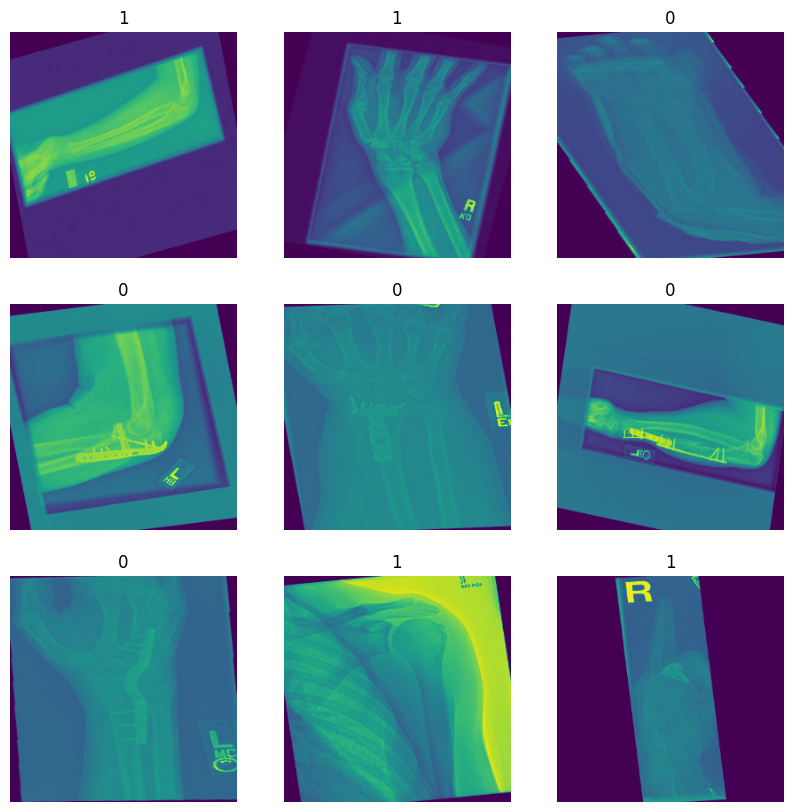

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [9]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(AUTOTUNE)
valid_ds = valid_ds.prefetch(AUTOTUNE)

In [10]:
def create_model(input_shape, num_classes):

    #create a Sequential  model
    model = Sequential()

    #Add the layers
    model.add(Input(input_shape))
    model.add(Rescaling(1.0 / 255))
    #Add 2 convolutional layers paired with max pooling layers
    model.add(Conv2D(filters = 64, kernel_regularizer=REGULARIZER, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 128, kernel_regularizer=REGULARIZER, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
   
    #Flatten the output so that it can be processed as a Vector by the subsequnet Dense layer
    model.add(Flatten())

    #add a fully connected layer with  64 neurons and a relu activation function ouput shape = 64
    model.add(Dense(64, kernel_regularizer=REGULARIZER, activation='relu'))
    #add output layer with a single neuron and a sigmoind activation to represent the binary classification
    model.add(Dense(1, kernel_regularizer=REGULARIZER, activation='sigmoid'))

    return model

In [11]:
model = create_model(input_shape=INPUT_SHAPE, num_classes=NUMBER_OF_CLASSES)
plot_model(model, show_shapes=True)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ activation[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 128, 128,  │     34,176 │ activation_1[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 128, 128,  │     68,096 │ activation_2[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     33,024 │ activation[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 256)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 64, 64,    │    133,888 │ activation_3[0][… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      2,048 │ separable_conv2d

 Total params: 2,728,761 (10.41 MB)

 Trainable params: 2,720,473 (10.38 MB)

 Non-trainable params: 8,288 (32.38 KB)

In [12]:
model.compile(optimizer=OPTIMIZER(),loss=LOSS_FUNCTION(),metrics=METRICS)

In [14]:
callbacks = [
             ModelCheckpoint(
                filepath= join(DATASET_DIRECTORY, 'checkpoints', nb_fname + '_checkpoint_at_{epoch}.keras'),
                monitor='val_accuracy',
                mode='max',
                save_best_only=True),
             BackupAndRestore(
                backup_dir= join(DATASET_DIRECTORY, 'backups', nb_fname + '_backup_at_{epoch}.keras'),
                save_freq="epoch",
                delete_checkpoint=True)
            ]

model_history = model.fit(
                        train_ds,
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data=valid_ds
                        )

clear_session

Epoch 1/25


2024-03-14 20:23:46.058562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


229/229 ━━━━━━━━━━━━━━━━━━━━ 121s 489ms/step - accuracy: 0.5151 - loss: 7.4984 - val_accuracy: 0.4971 - val_loss: 8.0896
Epoch 2/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 109s 473ms/step - accuracy: 0.5240 - loss: 7.4403 - val_accuracy: 0.5115 - val_loss: 7.5322
Epoch 3/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 110s 479ms/step - accuracy: 0.5121 - loss: 7.2911 - val_accuracy: 0.4885 - val_loss: 8.0830
Epoch 4/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 108s 471ms/step - accuracy: 0.5208 - loss: 7.4839 - val_accuracy: 0.5029 - val_loss: 7.8957
Epoch 5/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 107s 465ms/step - accuracy: 0.4887 - loss: 8.1521 - val_accuracy: 0.5029 - val_loss: 7.9108
Epoch 6/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 107s 466ms/step - accuracy: 0.4868 - loss: 8.1817 - val_accuracy: 0.5029 - val_loss: 7.8806
Epoch 7/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 107s 465ms/step - accuracy: 0.4879 - loss: 8.1493 - val_accuracy: 0.5029 - val_loss: 7.8806
Epoch 8/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 106s 464ms/step - accuracy: 0.4840 - loss: 8.22

<function keras.src.backend.common.global_state.clear_session()>

In [15]:
evaluation = model.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.4933 - loss: 8.1482


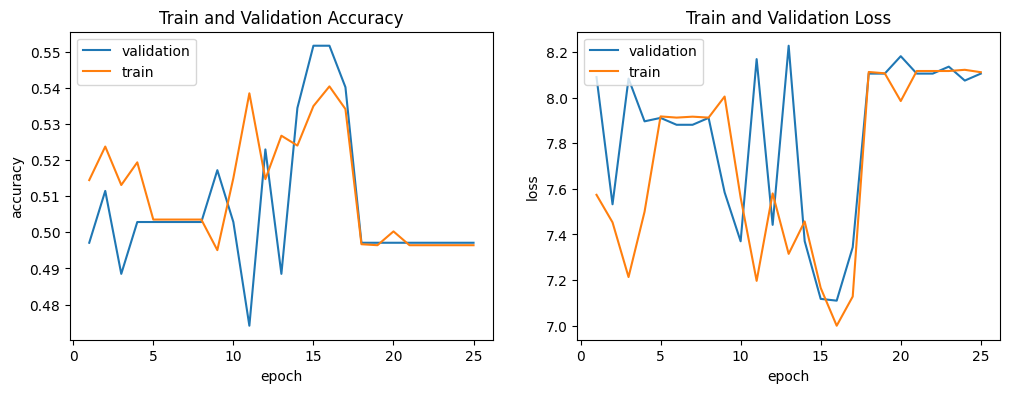

In [16]:
train_accuracy = model_history.history['accuracy']
valid_accuracy = model_history.history['val_accuracy']
train_loss = model_history.history['loss']
valid_loss = model_history.history['val_loss']

fig, (accuracy, loss) = plt.subplots(1, 2, sharex=True, sharey=False)
fig.set_size_inches(12,4 )
accuracy.plot(range(1, EPOCHS+1), valid_accuracy) 
accuracy.plot(range(1, EPOCHS+1), train_accuracy)  
accuracy.set_ylabel('accuracy')
accuracy.set_xlabel('epoch')
accuracy.legend(['validation','train'], loc='upper left')
accuracy.set_title('Train and Validation Accuracy')

loss.plot(range(1, EPOCHS+1), valid_loss)
loss.plot(range(1, EPOCHS+1), train_loss)
loss.set_ylabel('loss')
loss.set_xlabel('epoch')
loss.legend(['validation', 'train'], loc='upper left')
loss.set_title('Train and Validation Loss')

plt.show()